# Score-Based Generative Modeling


### Goals
This is a hitchhiker's guide to score-based generative models, a family of approaches based on [estimating gradients of the data distribution](https://arxiv.org/abs/1907.05600). They have obtained high-quality samples comparable to GANs (like below, figure from [this paper](https://arxiv.org/abs/2006.09011)) without requiring adversarial training, and are considered by some to be [the new contender to GANs](https://ajolicoeur.wordpress.com/the-new-contender-to-gans-score-matching-with-langevin-sampling/).

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import sys
import os
print(os.getcwd())
sys.path.append('../../..')
from contrib.DMI.ASIP_OSISAF.data_simple import *
from src.utils import *
from src.models import *
import matplotlib.pyplot as plt
import torch
import itertools
import geopandas as gpd
from geopandas import GeoSeries
import cartopy.feature as cfeature

datamodule = BaseDataModule(asip_paths="/dmidata/users/maxb/ASIP_OSISAF_dataset/PREPROC/asip_database_daw15.nc",
                            split_train=slice(0,900),
                            split_val=slice(900,950),
                            split_test=slice(950,1000))
                            
datamodule.setup()

data_loader = datamodule.train_dataloader()
val_dataloader = datamodule.val_dataloader()
test_dataloader = datamodule.test_dataloader()

/dmidata/users/maxb/4dvarnet-starter/Notebooks/Notebook_DMI/ASIP_OSISAF


In [3]:
k=10
my_sample = next(itertools.islice(data_loader, k, None))
print(my_sample[0].shape)

torch.Size([9, 8, 240, 240])


In [4]:
#@title Defining a time-dependent score-based model (double click to expand or collapse)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    ret = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
    return ret

class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps.
  Allow time repr to input additively from the side of a convolution layer.
  """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None,None] # add one dimension here with one more None

class ScoreNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, channels=[64, 128, 256, 512], 
                 embed_dim=256, 
                 text_dim=1, nAttr=40):
        """Initialize a time-dependent score-based network.

        Args:
          marginal_prob_std: A function that takes time t and gives the standard
            deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
                                   nn.Linear(embed_dim, embed_dim))
        # Encoding layers where the resolution decreases
        #self.conv1 = nn.Conv3d(3, channels[0], 3, stride=1,padding=1, bias=False)#change 25a: making 2 instead of 9 as Mahima code #change 49g: using corresponding with time-windows for 3D generative #change 50d 2*time_window by 2 here
        self.conv1 = nn.Conv3d(4, channels[0], 3, stride=1,padding=1, bias=False)#change 25a: making 2 instead of 9 as Mahima code #change 49g: using corresponding with time-windows for 3D generative #change 50d 2*time_window by 2 here
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv3d(channels[0], channels[1], 3, stride=2,padding=1, bias=False, )
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv3d(channels[1], channels[2], 3, stride=2,padding=1, bias=False, )
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        # self.attn3 = SpatialTransformer(channels[2], text_dim)
        self.conv4 = nn.Conv3d(channels[2], channels[3], 3, stride=2,padding=1, bias=False, )
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        # self.attn4 = SpatialTransformer(channels[3], text_dim)

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose3d(channels[3], channels[2], 3, stride=2, bias=False, padding=1, output_padding=1) #change 25b: add padding here
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        # self.attn5 = SpatialTransformer(channels[2], text_dim)
        self.tconv3 = nn.ConvTranspose3d(channels[2], channels[1], 3, stride=2, bias=False,
                                          padding=1, output_padding=1)  # , output_padding=1)     #  + channels[2]
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose3d(channels[1], channels[0], 3, stride=2, bias=False,
                                        padding=1, output_padding=1)  # , output_padding=1)     #  + channels[1]
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose3d(channels[0], 1, 3, stride=1,padding=1)  # + channels[0] #change 49o: must be time window in the output here #change 50e: time_window by 1 here

        # The swish activation function
        self.act = nn.SiLU()  # lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = nn.Embedding(nAttr + 1, text_dim, padding_idx=nAttr)  # +1 for the padding index

    def forward(self, x, t, y=None, boundaries = None, mask_boundaries = None, mask=None):
        
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.embed(t))
        # print('y', y.shape)

        #x= torch.cat((x, y, mask, boundaries), 1)
        x= torch.cat((x, y, boundaries, mask_boundaries), 1)
        # print('x after concating y', x.shape)

        # print('conv1 before add dense', self.conv1(x).shape)
        # print('dense1', self.dense1(embed).shape)
        h1 = self.conv1(x) + self.dense1(embed)
        # print('conv1 after add dense', h1.shape)

        h1 = self.act(self.gnorm1(h1))
        # print('conv2 before add dense', self.conv2(h1).shape)
        # print('dense2', self.dense2(embed).shape)
        h2 = self.conv2(h1) + self.dense2(embed)
        # print('conv2', h2.shape)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        # print('h3', h3.shape)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        # print('h4', h4.shape)
        
        # Decoding path
        h = self.tconv4(h4) + self.dense5(embed)
        # print('tconv4', h.shape)
        ## Skip connection from the encoding path
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3) + self.dense6(embed)
        # print('tconv3', h.shape)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2) + self.dense7(embed)
        # print('tconv2', h.shape)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)
        # print('tconv1', h.shape)
        
        # Normalize output
        h = h / self.marginal_prob_std(t)[:,None, None, None, None] #add one dimension for 3D setting here
        # print('final output', h.shape)
        # print("self.marginal_prob_std(t) 3D setting:", self.marginal_prob_std(t))
        return h

## Training with Weighted Sum of Denoising Score Matching Objectives

Now let's get our hands dirty on training. First of all, we need to specify an SDE that perturbs the data distribution $p_0$ to a prior distribution $p_T$. We choose the following SDE
\begin{align*}
d \mathbf{x} = \sigma^t d\mathbf{w}, \quad t\in[0,1]
\end{align*}
In this case,
\begin{align*}
p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0)) = \mathcal{N}\bigg(\mathbf{x}(t); \mathbf{x}(0), \frac{1}{2\log \sigma}(\sigma^{2t} - 1) \mathbf{I}\bigg)
\end{align*}
and we can choose the weighting function $\lambda(t) = \frac{1}{2 \log \sigma}(\sigma^{2t} - 1)$.

When $\sigma$ is large, the prior distribution, $p_{t=1}$ is
\begin{align*}
\int p_0(\mathbf{y})\mathcal{N}\bigg(\mathbf{x}; \mathbf{y}, \frac{1}{2 \log \sigma}(\sigma^2 - 1)\mathbf{I}\bigg) d \mathbf{y} \approx \mathbf{N}\bigg(\mathbf{x}; \mathbf{0}, \frac{1}{2 \log \sigma}(\sigma^2 - 1)\mathbf{I}\bigg),
\end{align*}
which is approximately independent of the data distribution and is easy to sample from.

Intuitively, this SDE captures a continuum of Gaussian perturbations with variance function $\frac{1}{2 \log \sigma}(\sigma^{2t} - 1)$. This continuum of perturbations allows us to gradually transfer samples from a data distribution $p_0$ to a simple Gaussian distribution $p_1$.

In [5]:
#@title Set up the SDE

import functools
device = 'cuda'
#device = 'cpu' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The sigma in our SDE.

  Returns:
    The standard deviation.
  """
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The sigma in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)

sigma =  25.0#@param {'type':'number'}
#sigma = 5.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [6]:
#@title Define the loss function (double click to expand or collapse)

def loss_fn(model, x, y, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x).to(device)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, y, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

def masked_loss_fn(model, x,  y, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
    
  boundaries = torch.clone(x)
  boundaries[:, :, :, 20:220, 20:220] = 0
  boundaries = torch.nan_to_num(boundaries)  
  mask_boundaries = torch.where(boundaries==0.,0.,1.)
  mask = ~torch.isnan(x)  # mask is True where x is not NaN
  mask_obs = ~torch.isnan(y)
  x = torch.nan_to_num(x)  
  y = torch.nan_to_num(y)  
  
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None, None] # add one dimension here
  score = model(perturbed_x, t=random_t, y=y, 
                boundaries=boundaries, mask_boundaries=mask_boundaries)#, mask=mask_obs)
  
  # Step 2: Compute the loss as usual
  loss = (score * std[:, None, None, None, None] + z) ** 2 # add one dimension here
  
  # Step 3: Apply the mask
  loss = loss * mask.float()  # Only consider non-NaN pixels
  
  # Step 4: Compute the mean loss over valid pixels
  loss = torch.sum(loss, dim=(1, 2, 3))  # Sum over spatial dimensions
  valid_pixel_count = torch.sum(mask, dim=(1, 2, 3))  # Count valid pixels
  loss = loss / valid_pixel_count  # Normalize loss by valid pixel count
  loss = torch.mean(loss)  # Average over the batch
  return loss

## Sampling with Numerical SDE Solvers
Recall that for any SDE of the form
\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) dt + g(t) d\mathbf{w},
\end{align*}
the reverse-time SDE is given by
\begin{align*}
d \mathbf{x} = [\mathbf{f}(\mathbf{x}, t) - g(t)^2 \nabla_\mathbf{x} \log p_t(\mathbf{x})] dt + g(t) d \bar{\mathbf{w}}.
\end{align*}
Since we have chosen the forward SDE to be
\begin{align*}
d \mathbf{x} = \sigma^t d\mathbf{w}, \quad t\in[0,1]
\end{align*}
The reverse-time SDE is given by
\begin{align*}
d\mathbf{x} = -\sigma^{2t} \nabla_\mathbf{x} \log p_t(\mathbf{x}) dt + \sigma^t d \bar{\mathbf{w}}.
\end{align*}
To sample from our time-dependent score-based model $s_\theta(\mathbf{x}, t)$, we first draw a sample from the prior distribution $p_1 \approx \mathbf{N}\bigg(\mathbf{x}; \mathbf{0}, \frac{1}{2}(\sigma^{2} - 1) \mathbf{I}\bigg)$, and then solve the reverse-time SDE with numerical methods.

In particular, using our time-dependent score-based model, the reverse-time SDE can be approximated by
\begin{align*}
d\mathbf{x} = -\sigma^{2t} s_\theta(\mathbf{x}, t) dt + \sigma^t d \bar{\mathbf{w}}
\end{align*}

Next, one can use numerical methods to solve for the reverse-time SDE, such as the [Euler-Maruyama](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method) approach. It is based on a simple discretization to the SDE, replacing $dt$ with $\Delta t$ and $d \mathbf{w}$ with $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, g^2(t) \Delta t \mathbf{I})$. When applied to our reverse-time SDE, we can obtain the following iteration rule
\begin{align}
\mathbf{x}_{t-\Delta t} = \mathbf{x}_t + \sigma^{2t} s_\theta(\mathbf{x}_t, t)\Delta t + \sigma^t\sqrt{\Delta t} \mathbf{z}_t,
\end{align}
where $\mathbf{z}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.

In [7]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)
from tqdm.autonotebook import tqdm

## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
#num_steps = 100

def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           y,
                           boundaries, 
                           mask_boundaries,
                           batch_size=64,
                           num_steps=num_steps,
                           device='cuda',
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(y.size(), device=device) \
    * marginal_prob_std(t)[:, None,None,None,None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  tqdm_time_steps = tqdm(time_steps)    
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  mask_obs = ~torch.isnan(y)
  y = y.nan_to_num()
  with torch.no_grad():
    for time_step in tqdm_time_steps:
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None,None,None,None] * score_model(x, batch_time_step, y,
                                                                boundaries, mask_boundaries, mask_obs) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None,None,None,None] * torch.randn_like(x)
  # Do not include any noise in the last sampling step.
  return mean_x

# Training

## Understanding this Supervised Loss: how it works intuitively

### First, some basic knowledge about Gaussian distribution


We start by proving: $\nabla_x \log \mathcal{N}(x; \mu, \Sigma) = -\Sigma^{-1} (x - \mu)$
Indeed, the probability density function of a Gaussian (normal) distribution $ \mathcal{N}(x; \mu, \Sigma) $ is given by:
$$
p(x) = \frac{1}{\sqrt{(2\pi)^d |\Sigma|}} \exp\left(-\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu)\right)
$$
where:
- $\mu$ is the mean vector, $\Sigma$ is the covariance matrix, $d$ is the dimensionality of $x$, $|\Sigma|$ is the determinant of the covariance matrix.

Then the log of the Gaussian probability density is:
$$
\log p(x) = -\frac{d}{2} \log(2\pi) - \frac{1}{2} \log |\Sigma| - \frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu)
$$

Take the gradient of the log probability with respect to $x$:
$$
\nabla_x \log p(x) = \nabla_x \left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)
$$
Using matrix calculus, the gradient of the quadratic form is:
$$
\nabla_x \left( (x - \mu)^T \Sigma^{-1} (x - \mu) \right) = 2 \Sigma^{-1} (x - \mu)
$$
Thus, the score function is:
$$
\nabla_x \log p(x) = -\Sigma^{-1} (x - \mu)
$$

### Now, we try to understand the Loss with Transition Probability as a Gaussian

In the context of the score-based generative model, the perturbation process from \( x(0) \) to \( x(t) \) is modeled as a Gaussian:

$
p_{0t}(x(t) \mid x(0)) = \mathcal{N}(x(t); x(0), \text{std}^2(t) I).
$

The Gaussian form of the transition probability:

$$
p_{0t}(x(t) \mid x(0)) = \frac{1}{(2\pi \text{std}^2(t))^{d/2}} \exp\left(-\frac{\|x(t) - x(0)\|^2}{2 \text{std}^2(t)}\right).
$$

Compute the gradient of the log probability with respect to $x(t)$:

$$
\log p_{0t}(x(t) \mid x(0)) = -\frac{d}{2} \log(2\pi \text{std}^2(t)) - \frac{\|x(t) - x(0)\|^2}{2 \text{std}^2(t)}
$$

Taking the gradient with respect to $ x(t) $:

$$
\nabla_{x(t)} \log p_{0t}(x(t) \mid x(0)) = -\nabla_{x(t)} \left(\frac{\|x(t) - x(0)\|^2}{2 \text{std}^2(t)}\right)
$$


Thus, the score function is:

$$
\nabla_{x(t)} \log p_{0t}(x(t) \mid x(0)) = -\frac{x(t) - x(0)}{\text{std}^2(t)}
$$

#### Substitution with Perturbation

Given that $ x(t) = x(0) + z \cdot \text{std}(t) $, substitute into the expression:

$$
x(t) - x(0) = z \cdot \text{std}(t)
$$

Substitute into the score function:

$$
\nabla_{x(t)} \log p_{0t}(x(t) \mid x(0)) = -\frac{z \cdot \text{std}(t)}{\text{std}^2(t)} = -\frac{z}{\text{std}(t)}
$$

This yields:

$$
\nabla_{x(t)} \log p_{0t}(x(t) \mid x(0)) = -\frac{z}{\text{std}(t)}
$$

**And this explains why we have below loss function.**

In [11]:
#@title Training (double click to expand or collapse)

from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import warnings
warnings.filterwarnings('ignore')

n_epochs =  1000#@param {'type':'integer'}
## learning rate
lr = 2e-4 #@param {'type':'number'}

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)
ckpt = torch.load('ckpt/ckpt_diff_srnn_ASIP_add_bound.pth', map_location=device)
score_model.load_state_dict(ckpt)

optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[100, 200, 300, 400,450, 600,800,1000,1200,1400], gamma=0.5)

tqdm_epoch = tqdm(range(n_epochs))
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for batch in data_loader:
    #batch = batch.nan_to_num().to(device)
    x = batch[:,0,:,:,:].to(device) # ASIP data
    y = batch[:,1,:,:,:].to(device) # OSISAF data
    #y = F.avg_pool2d(x,kernel_size=11, stride=1, padding=(5,5), count_include_pad=False) # coarsen_ASIP (*10)
    """
    xr.Dataset(data_vars={'ssh':(('time','lat','lon'),x.detach().cpu()[0])},
           coords={'time':np.arange(8),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).ssh.plot(col='time',col_wrap=8,vmin=0,vmax=1)
    plt.show()
    xr.Dataset(data_vars={'ssh':(('time','lat','lon'),y.detach().cpu()[0])},
           coords={'time':np.arange(8),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).ssh.plot(col='time',col_wrap=8,vmin=0,vmax=1)
    plt.show()
    """
    x = torch.unsqueeze(x, 1)
    y = torch.unsqueeze(y, 1)
    loss = masked_loss_fn(score_model, x, y, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt/ckpt_diff_srnn_ASIP_add_bound.pth')
  scheduler.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import cmcrameri as cmc

def truncate_colormap(cmap, minval=0.0, maxval=1.0,n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
                             'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name,
                              a=minval, b=maxval),
                              cmap(np.linspace(minval, maxval, n)))
    return new_cmap

sic_trunc = truncate_colormap(cmc.cm.oslo, minval=0.2, maxval=1, n=100)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

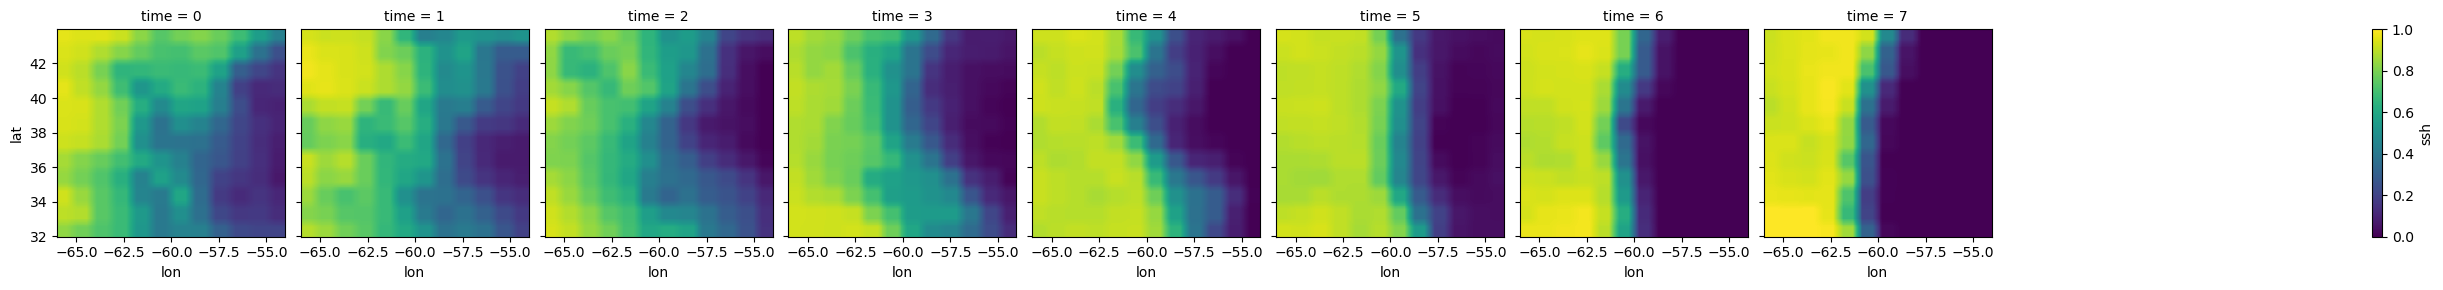

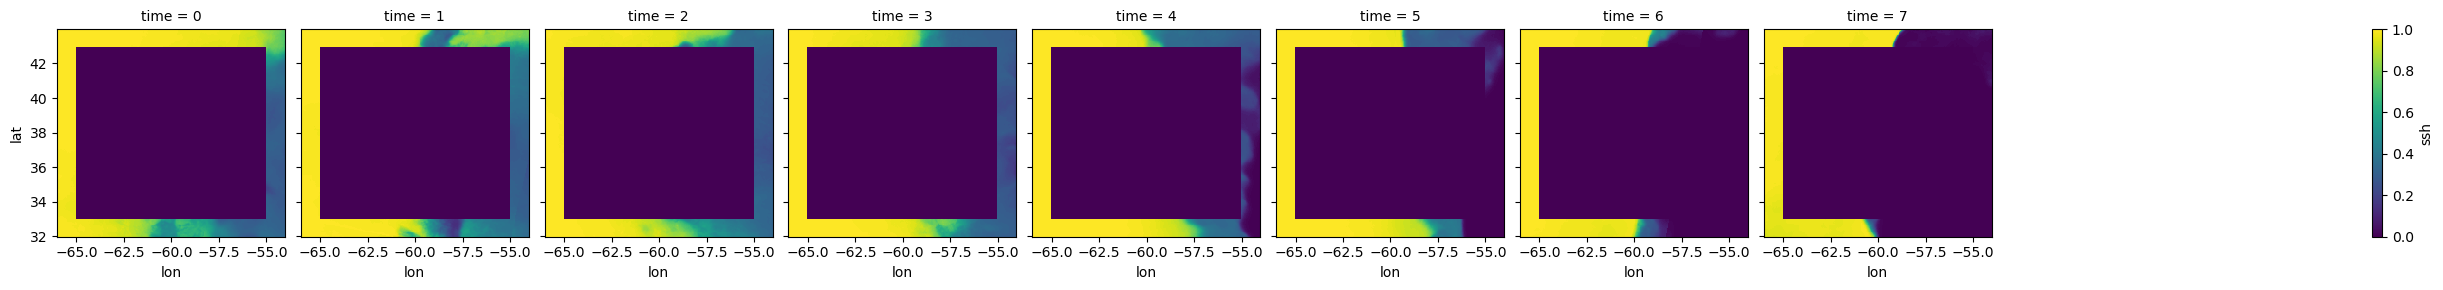

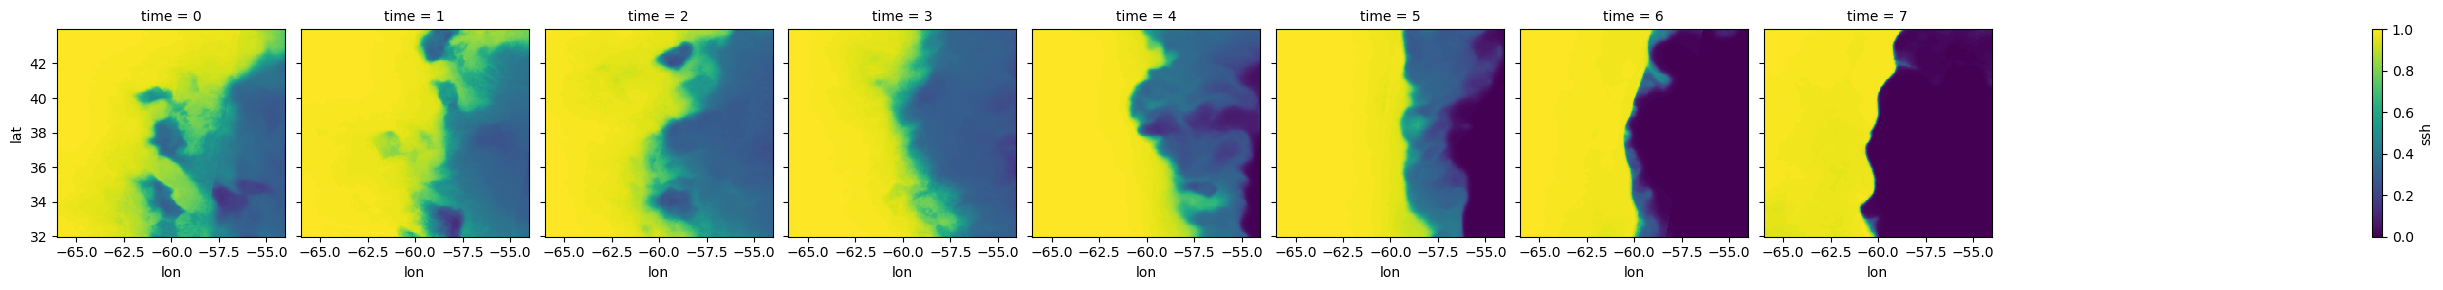

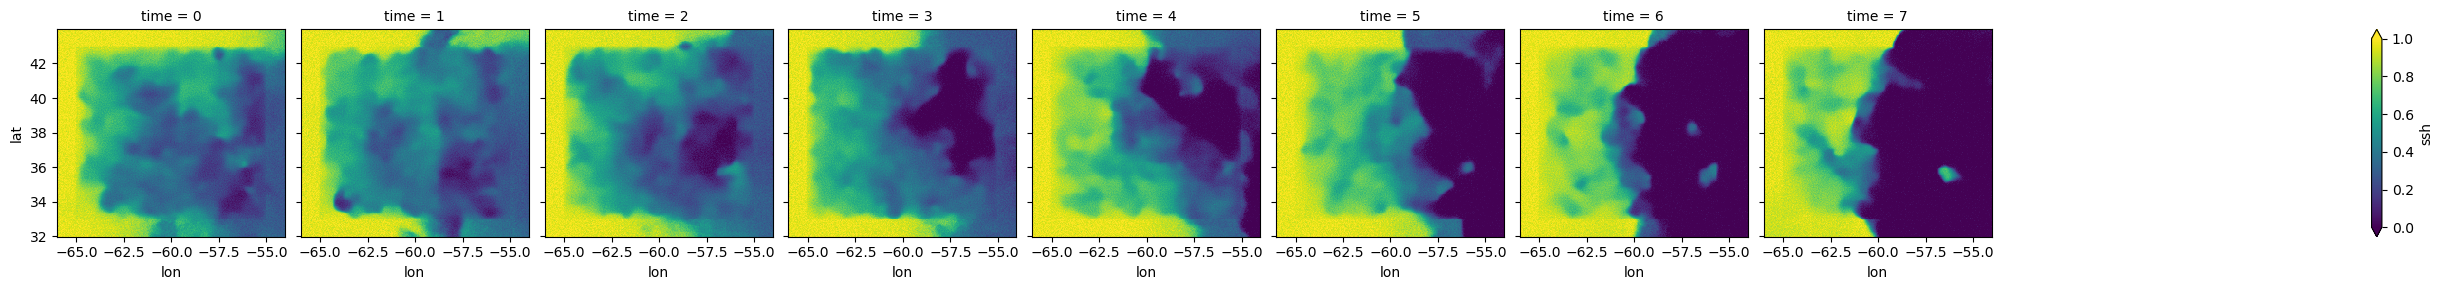

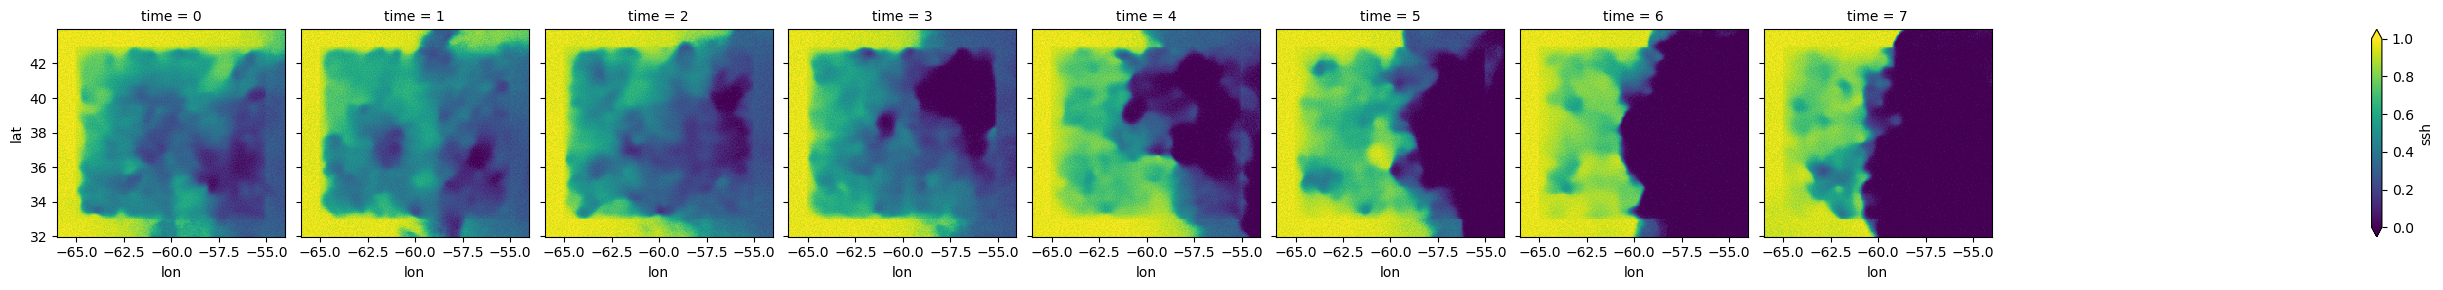

In [13]:
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)
ckpt = torch.load('ckpt/ckpt_diff_srnn_ASIP_add_bound.pth', map_location=device)
score_model.load_state_dict(ckpt)


k = 10
batch = next(itertools.islice(data_loader, k, None))
x = batch[:,0,:,:,:].to(device) # ASIP data
y = batch[:,1,:,:,:].to(device) # OSISAF data
x = torch.unsqueeze(x, 1)
y = torch.unsqueeze(y, 1)
boundaries = torch.clone(x)
boundaries[:, :, :, 20:220, 20:220] = 0
boundaries = torch.nan_to_num(boundaries)  
mask_boundaries = torch.where(boundaries==0.,0.,1.)
#x = x[[0]]
#std = marginal_prob_std(1,25)
#z = torch.randn_like(x)
#x = x + z * std
#y = y[[0]]

sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
x_estim = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  y.nan_to_num().to(device),
                  boundaries.to(device),
                  mask_boundaries.to(device),
                  batch_size=x.shape[0],
                  num_steps=500,
                  device=device)
x_estim2 = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  y.nan_to_num().to(device),
                  boundaries.to(device),
                  mask_boundaries.to(device),
                  batch_size=x.shape[0],
                  num_steps=500,
                  device=device)

x = x.squeeze()
boundaries = boundaries.squeeze()
mask_boundaries = mask_boundaries.squeeze()

if len(x.shape)==3:
    x = torch.unsqueeze(x, 0)
y = y.squeeze()
if len(y.shape)==3:
    y = torch.unsqueeze(y, 0)
x_estim = x_estim.squeeze()
if len(x_estim.shape)==3:
    x_estim = torch.unsqueeze(x_estim, 0)
x_estim2 = x_estim2.squeeze()
if len(x_estim2.shape)==3:
    x_estim2 = torch.unsqueeze(x_estim2, 0)
    
x_estim[torch.isnan(y)] = np.nan
xr.Dataset(data_vars={'SIC':(('time','lat','lon'),y.detach().cpu()[0])},
           coords={'time':np.arange(8),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).SIC.plot(col='time',col_wrap=15,vmin=0,vmax=1,cmap=sic_trunc,
                                                            cbar_kwargs={'shrink': 1.5, 'aspect': 15})
plt.show()
xr.Dataset(data_vars={'SIC':(('time','lat','lon'),boundaries.detach().cpu()[0])},
           coords={'time':np.arange(8),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).SIC.plot(col='time',col_wrap=15,vmin=0,vmax=1,cmap=sic_trunc,
                                                            cbar_kwargs={'shrink': 1.5, 'aspect': 15})
plt.show()
xr.Dataset(data_vars={'SIC':(('time','lat','lon'),x.detach().cpu()[0])},
           coords={'time':np.arange(8),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).SIC.plot(col='time',col_wrap=15,vmin=0,vmax=1,cmap=sic_trunc,
                                                            cbar_kwargs={'shrink': 1.5, 'aspect': 15})
plt.show()
xr.Dataset(data_vars={'SIC':(('time','lat','lon'),x_estim.detach().cpu()[0])},
           coords={'time':np.arange(8),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).SIC.plot(col='time',col_wrap=15,vmin=0,vmax=1,cmap=sic_trunc,
                                                            cbar_kwargs={'shrink': 1.5, 'aspect': 15})
plt.show()
xr.Dataset(data_vars={'SIC':(('time','lat','lon'),x_estim2.detach().cpu()[0])},
           coords={'time':np.arange(8),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).SIC.plot(col='time',col_wrap=15,vmin=0,vmax=1,cmap=sic_trunc,
                                                            cbar_kwargs={'shrink': 1.5, 'aspect': 15})
plt.show()